In [1]:
import os
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Callable
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from alibi.datasets import fetch_adult
from alibi_detect.cd import ClassifierDrift

%load_ext autoreload
%autoreload 2

## Load Adult Census Dataset

In [2]:
# fetch adult dataset
adult = fetch_adult()

# separate columns in numerical and categorical.
categorical_names = [adult.feature_names[i] for i in adult.category_map.keys()]
categorical_ids = list(adult.category_map.keys())

numerical_names = [name for i, name in enumerate(adult.feature_names) if i not in adult.category_map.keys()]
numerical_ids = [i for i in range(len(adult.feature_names)) if i not in adult.category_map.keys()]

# split data into train and test
X = adult.data

We split the dataset in two based on the education level. We define a `low_education` level consisting of: `'Dropout'`, `'High School grad'`, `'Bachelors'`, and a `high_education` level consisting of: `'Bachelors'`, `'Masters'`, `'Doctorate'`. Intentionally we included an overlap between the two distribution consisting of people that have a `Bachelors` degree. Our goal is to detect that the two distributions are different.

In [3]:
education_col = adult.feature_names.index('Education')
education = adult.category_map[education_col]
print(education)

['Associates', 'Bachelors', 'Doctorate', 'Dropout', 'High School grad', 'Masters', 'Prof-School']


In [4]:
# define low education
low_education = [
    education.index('Dropout'),
    education.index('High School grad'),
    education.index('Bachelors')
    
]
# define high education
high_education = [
    education.index('Bachelors'),
    education.index('Masters'),
    education.index('Doctorate')
]
print("Low education:", [education[i] for i in low_education])
print("High education:", [education[i] for i in high_education])

Low education: ['Dropout', 'High School grad', 'Bachelors']
High education: ['Bachelors', 'Masters', 'Doctorate']


In [5]:
# select instances for low and high education
low_education_mask = pd.Series(X[:, education_col]).isin(low_education).to_numpy()
high_education_mask = pd.Series(X[:, education_col]).isin(high_education).to_numpy()
X_low, X_high = X[low_education_mask], X[high_education_mask]

We sample our reference dataset from the `low_education` level. In addition, we sample two other datasets:

 * `x_h0` - sampled form the `low_education` level to support the null hypothesis (i.e., the two distribution are identical);

* `x_h1` - sampled from the `high_education` level to support the alternative hypothesis (i.e., the two distributions are different);

In [6]:
size = 1000
np.random.seed(0)

# define reference and H0 dataset
idx_low = np.random.choice(np.arange(X_low.shape[0]), size=2*size, replace=False)
x_ref, x_h0 = train_test_split(X_low[idx_low], test_size=0.5, random_state=5, shuffle=True)

# define reference and H1 dataset
idx_high = np.random.choice(np.arange(X_high.shape[0]), size=size, replace=False)
x_h1 = X_high[idx_high]

## Define dataset pre-processor

In [7]:
# define numerical standard scaler.
num_transf = StandardScaler()

# define categorical one-hot encoder.
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    handle_unknown="ignore"
)

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transf, categorical_ids),
        ("num", num_transf, numerical_ids),
    ],
    sparse_threshold=0
)

# fit preprocessor.
preprocessor = preprocessor.fit(np.concatenate([x_ref, x_h0, x_h1]))

## Utils

In [8]:
labels = ['No!', 'Yes!']

def print_preds(preds: dict, preds_name: str) -> None:
    print(preds_name)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print('')

## Drift detection 

We perform a **binomial** test using a `RandomForestClassifier`. 

In [9]:
# define classifier
model = RandomForestClassifier()

# define drift detector with binarize prediction
detector = ClassifierDrift(
    x_ref=x_ref,
    model=model,
    backend='sklearn',
    preprocess_fn=preprocessor.transform,
    binarize_preds=True,
    n_folds=2,
)

# print results
print_preds(detector.predict(x=x_h0), "H0")
print_preds(detector.predict(x=x_h1), "H1")

Both `n_folds` and `train_size` specified. By default `n_folds` is used.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.
`use_oob=False` sets automatically the parameter `oob_score=False`


H0
Drift? No!
p-value: 0.681

H1
Drift? Yes!
p-value: 0.000



As expected, when testing against `x_h0`, we fail to reject $H_0$, while for the second case there is enough evidence to reject $H_0$ and flag that the data has drifted.

For the classifiers that do not support `predict_proba`, but offer support for `decision_function`, we can perform a **K-S** test on the scores by setting `preds_type='scores'`.

In [10]:
# define model - does not support predict_proba
model = LinearSVC(max_iter=10000)

# define drift detector with binarize prediction
detector = ClassifierDrift(
    x_ref=x_ref,
    model=model,
    backend='sklearn',
    preprocess_fn=preprocessor.transform,
    preds_type='scores',
    binarize_preds=False,
    n_folds=2,
)

# print results
print_preds(detector.predict(x=x_h0), "H0")
print_preds(detector.predict(x=x_h1), "H1")

Both `n_folds` and `train_size` specified. By default `n_folds` is used.


H0
Drift? No!
p-value: 0.171

H1
Drift? Yes!
p-value: 0.000



Furthermore, we can add calibration on top of each classifier and perform a **K-S** or a **binomial** test.

In [11]:
# define model - does not support predict_proba
model = GradientBoostingClassifier()

# define drift detector with binarize prediction
detector = ClassifierDrift(
    x_ref=x_ref,
    model=model,
    backend='sklearn',
    preprocess_fn=preprocessor.transform,
    binarize_preds=False,
    n_folds=2,
    use_calibration=True,
    calibration_kwargs={'method': 'isotonic'}
)

# print results
print_preds(detector.predict(x=x_h0), "H0")
print_preds(detector.predict(x=x_h1), "H1")

Both `n_folds` and `train_size` specified. By default `n_folds` is used.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.
Using calibration to obtain the prediction probabilities.


H0
Drift? No!
p-value: 0.886

H1
Drift? Yes!
p-value: 0.000



We can use Shap to identify the features that caused the drift.

In [20]:
def plot_shap(prediction, feature_names):
    ord_idx = np.argsort(prediction['data']['shap'])
    ord_feat = [feature_names[i] for i in ord_idx]
    ord_vals = prediction['data']['shap'][ord_idx]
    plt.barh(ord_feat, ord_vals)
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

H1
Drift? Yes!
p-value: 0.000



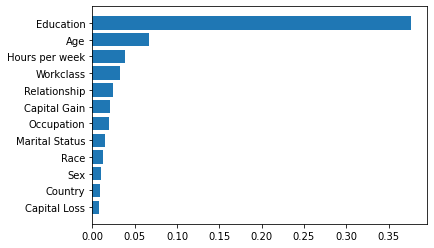

In [21]:
# define classifier
model = DecisionTreeClassifier()

# define drift detector with binarize prediction
detector = ClassifierDrift(
    x_ref=x_ref,
    model=model,
    backend='sklearn',
    preprocess_fn=preprocessor.transform,
    binarize_preds=False,
    use_shap=True,
    shap_kwargs={'summarise_background': True,
                 'n_background_samples': 50,
                 'n_samples': 50,
                 'feature_names': adult.feature_names,
                 'categorical_names': adult.category_map,
#                  'distributed_opts': {'n_cpus': 8}
    }
)

# print results
prediction = detector.predict(x=x_h1)
print_preds(output, "H1")
plot_shap(prediction, adult.feature_names)

Using Shap, we are able to correctly identify the `Education` feature as the cause of drift.